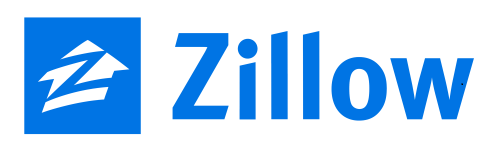
# Zillow Property Analysis - Initial Plan


# 📖 Overview

This notebook presents a **structured and reproducible workflow** for **preprocessing and exploring Zillow property data**.  
The project emphasizes effective **data cleaning** and **feature engineering** techniques, preparing the dataset for deeper **real estate insights** and future **modeling** tasks.

The primary objective is to **streamline the processing of raw Zillow data**, transforming it into a **structured and insightful format**.  
This work lays a strong foundation for potential extensions such as **predictive modeling**, **dashboard development**, and broader **real estate market analysis**.  
While designed to simulate a scalable data pipeline, this project focuses on processing a static dataset and showcasing **best practices** that can be adapted for automated ingestion workflows.

---

## 💡 What does this notebook do?

- Imports raw Zillow property data from a compressed **`.zip`** file.
- Cleans the data by handling **missing values**, **inconsistent formatting**, and **irrelevant columns**.
- Transforms **categorical**, **numerical**, and **date** features for easier analysis.
- Builds a solid foundation for further **exploratory analysis**, **visualizations**, and **machine learning** modeling.

---

## 🧹 Key Steps in Preprocessing:

- Decompressed and loaded data efficiently from a **zipped format**.
- Standardized key features (e.g., **price**, **date**, **property characteristics**).
- Handled missing data with logical strategies like **imputation** or **removal**.
- Structured complex features (e.g., **tax information**, **mortgages**, **nearby houses**, **nearby schools**) into usable formats.
- Created **new engineered features** to enhance future analysis.

---


 ### Importing Libraries

In [4]:
# ================================
# 📊 Data Handling & Manipulation
# ================================
import pandas as pd
import numpy as np
import zipfile

# ================================
# 📈 Data Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# ⚙️ System & Warnings Handling
# ================================
import warnings
warnings.filterwarnings("ignore")

# ================================
# 🧠 Machine Learning - Scikit-learn
# ================================

# Linear Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# Tree-Based and Ensemble Models
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    StackingRegressor
)

# Preprocessing and Evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ================================
# 🚀 Boosting Libraries
# ================================
import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor, Pool


## 1. Data Loading

In [6]:
# Open the ZIP file
zip_path = "data/Zillow.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Now load each file from the zip directly
    with zip_ref.open('property_listings.csv') as file:
        lp = pd.read_csv(file)
    
    with zip_ref.open('listing_subtype.csv') as file:
        subtype = pd.read_csv(file)
    
    with zip_ref.open('listing_price_history.csv') as file:
        pr_his = pd.read_csv(file)
    
    with zip_ref.open('listing_nearby_homes.csv') as file:
        pr_homes = pd.read_csv(file)
    
    with zip_ref.open('listing_schools_info.csv') as file:
        ne_sch = pd.read_csv(file)
    
    with zip_ref.open('listing_tax_info.csv') as file:
        tax = pd.read_csv(file)
    
    with zip_ref.open('listing_mortgage_info.csv') as file:
        mortgage = pd.read_csv(file)


## 🔹 Strategic Merging Operations

In this project, merging different Zillow datasets carefully and thoughtfully was a critical part of building a clean, reliable final dataset.

Each merge was treated as a mini-puzzle:
- Ensuring correct join type (e.g., inner join to maintain data integrity),
- Avoiding duplication of columns,
- Preserving the primary key ('zpid') structure,
- Reordering columns for better usability,
- Planning ahead for future ML operations.

This attention to merging was essential for the success of later steps like missing value imputation, outlier handling, and modeling.


### Subtype

In [9]:
for df_name, df in [('subtype', subtype), ('tax', tax), ('mortgage', mortgage)]:
    print(f"{df_name} unique zpid count: {df['zpid'].nunique()}")
    print(f"{df_name} total rows: {len(df)}")


subtype unique zpid count: 18415
subtype total rows: 18415
tax unique zpid count: 14395
tax total rows: 362631
mortgage unique zpid count: 18251
mortgage total rows: 98502


In [10]:
subtype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18415 entries, 0 to 18414
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   zpid            18415 non-null  int64 
 1   is_FSBA         18415 non-null  bool  
 2   is_comingSoon   18415 non-null  bool  
 3   is_newHome      18415 non-null  bool  
 4   is_pending      18415 non-null  bool  
 5   is_forAuction   18415 non-null  bool  
 6   is_foreclosure  18415 non-null  bool  
 7   is_bankOwned    18415 non-null  bool  
 8   is_openHouse    18415 non-null  bool  
 9   is_FSBO         18415 non-null  bool  
 10  lastUpdated     18415 non-null  object
dtypes: bool(9), int64(1), object(1)
memory usage: 449.7+ KB


In [11]:
# Rename the lastUpdated column in df1 to differentiate it
subtype = subtype.rename(columns={'lastUpdated': 'lastUpdated_subtype'})

### Property Listings

In [13]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18778 entries, 0 to 18777
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   zpid             18777 non-null  float64
 1   price            18777 non-null  float64
 2   homeStatus       18777 non-null  object 
 3   homeType         18777 non-null  object 
 4   datePosted       18750 non-null  object 
 5   streetAddress    18777 non-null  object 
 6   city             18777 non-null  object 
 7   state            18777 non-null  object 
 8   zipcode          18777 non-null  float64
 9   county           18763 non-null  object 
 10  yearBuilt        18025 non-null  float64
 11  livingArea       17669 non-null  float64
 12  livingAreaUnits  17673 non-null  object 
 13  rentZestimate    13691 non-null  float64
 14  bathrooms        18304 non-null  float64
 15  bedrooms         18119 non-null  float64
 16  pageViewCount    18776 non-null  float64
 17  favoriteCoun

##### Checking for duplicates in Property Listings

In [15]:
# 1. Identify duplicate 'zpid' entries in lp
lp_duplicates = lp[lp['zpid'].duplicated(keep=False)]
print("Duplicate entries based on 'zpid':", lp_duplicates.shape)

# 2. Drop duplicates, keeping the first occurrence
lp_new = lp.drop_duplicates(subset='zpid', keep='first')
print("Shape after removing duplicates:", lp_new.shape)


Duplicate entries based on 'zpid': (716, 23)
Shape after removing duplicates: (18416, 23)


### 🔹 Merge Step : Subtype + Property Listings
First, we merge the listing subtype information with the cleaned property listings based on the unique identifier 'zpid'.


In [17]:
# 1. Merge the DataFrames on 'zpid'
me_1 = pd.merge(subtype, lp_new, on='zpid', how='inner')  # Adjust 'how' as needed

# 2. Reorder columns: zpid → lp_new columns → subtype columns
lp_cols = [col for col in lp_new.columns if col != 'zpid']
subtype_cols = [col for col in subtype.columns if col != 'zpid']
me_1 = me_1[['zpid'] + lp_cols + subtype_cols]


In [18]:
me_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18415 entries, 0 to 18414
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zpid                 18415 non-null  int64  
 1   price                18415 non-null  float64
 2   homeStatus           18415 non-null  object 
 3   homeType             18415 non-null  object 
 4   datePosted           18390 non-null  object 
 5   streetAddress        18415 non-null  object 
 6   city                 18415 non-null  object 
 7   state                18415 non-null  object 
 8   zipcode              18415 non-null  float64
 9   county               18401 non-null  object 
 10  yearBuilt            17672 non-null  float64
 11  livingArea           17318 non-null  float64
 12  livingAreaUnits      17322 non-null  object 
 13  rentZestimate        13390 non-null  float64
 14  bathrooms            17948 non-null  float64
 15  bedrooms             17763 non-null 

## 🔹 Date and Time Feature Engineering

To better capture temporal dynamics of listings, several transformations were performed together:

- Converted `timeOnZillow` into total hours.
- Calculated the number of days since the last update (`lastUpdated`) and the original posting date (`datePosted`).
- Dropped redundant or less useful columns such as `lastUpdated_subtype`, `dateSold`, `datePosted`, `timeOnZillow`, `lastUpdated`, and `rentZestimate` to streamline the dataset.

These steps were grouped together intentionally to maintain a clear, logical flow, reduce cell fragmentation, and improve notebook readability.


In [20]:
# --- Convert 'timeOnZillow' to hours ---
def convert_to_hours(duration):
    if isinstance(duration, str):
        if 'day' in duration:
            days = int(duration.split()[0])
            return days * 24
        elif 'hour' in duration:
            return int(duration.split()[0])
    elif isinstance(duration, (int, float)):
        return duration
    return 0  # fallback for unexpected types

me_1['duration_in_hours'] = me_1['timeOnZillow'].apply(convert_to_hours)
print(me_1['duration_in_hours'].head())

# --- Handle date columns and calculate durations ---
today = pd.to_datetime('today')

# Convert and localize 'lastUpdated'
me_1['lastUpdated'] = pd.to_datetime(me_1['lastUpdated']).dt.tz_localize(None)
me_1['latest_Updated'] = (today - me_1['lastUpdated']).dt.days

# Convert 'datePosted' and calculate days since posting
me_1['datePosted'] = pd.to_datetime(me_1['datePosted'])
me_1['days_since'] = (today - me_1['datePosted']).dt.days

# --- Drop unneeded columns ---
me_1.drop(columns=['lastUpdated_subtype', 'dateSold', 'datePosted', 'timeOnZillow', 'lastUpdated','rentZestimate'], inplace=True)


0    24.0
1    24.0
2    24.0
3    24.0
4    24.0
Name: duration_in_hours, dtype: float64


## 🔹 Handling Critical Missing Values (Bedrooms and Bathrooms)

- Identified listings missing essential structural information (`bathrooms` or `bedrooms`).
- Decided **not to impute** these fields because imputing critical features like bedrooms/bathrooms can introduce major biases into the model.
- Dropped rows where either of these fields was missing to ensure the dataset remains reliable.
- Monitored the dataset shape before and after cleaning to maintain transparency.

This decision helps preserve the physical integrity of the housing data, leading to better modeling outcomes.


In [22]:
# 1. Identify and count rows with NaN in 'bathrooms' or 'bedrooms'
nan_rows = me_1[me_1[['bathrooms', 'bedrooms']].isnull().any(axis=1)]
nan_counts = me_1[['bathrooms', 'bedrooms']].isnull().sum()
print("Rows with missing 'bathrooms' or 'bedrooms':", nan_rows.shape)
print("Missing values count:\n", nan_counts)

# 2. Drop those rows
df_cleaned = me_1.dropna(subset=['bathrooms', 'bedrooms'])

# 3. Display shape changes
print(f"Original DataFrame shape: {me_1.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")


Rows with missing 'bathrooms' or 'bedrooms': (709, 30)
Missing values count:
 bathrooms    467
bedrooms     652
dtype: int64
Original DataFrame shape: (18415, 30)
Cleaned DataFrame shape: (17706, 30)


## 🔹 Price Segmentation for Classification

To prepare for future classification tasks, I segmented the listing prices into four categories:

- **Low**: Listings priced at or below $300,000
- **Medium**: Listings priced between $300,001 and $1,000,000
- **High**: Listings priced between $1,000,001 and $10,000,000
- **Luxury**: Listings priced above $10,000,000

### Why Segmentation?

This segmentation serves as a **target variable** for any **future classification modeling**. The price categories can be useful to predict and understand different pricing behaviors.

### Distribution of Price Segments:

Below is a bar plot that illustrates the distribution of listings across these price categories. It provides insights into the **balance** of the data and the **prevalence** of each segment.

 

In [24]:
me_1.price.describe()

count    1.841500e+04
mean     6.745609e+05
std      3.665336e+06
min      0.000000e+00
25%      2.520000e+05
50%      3.999990e+05
75%      6.900000e+05
max      4.750000e+08
Name: price, dtype: float64

price_segment
Medium    9784
Low       6225
High      2370
Luxury      36
Name: count, dtype: int64


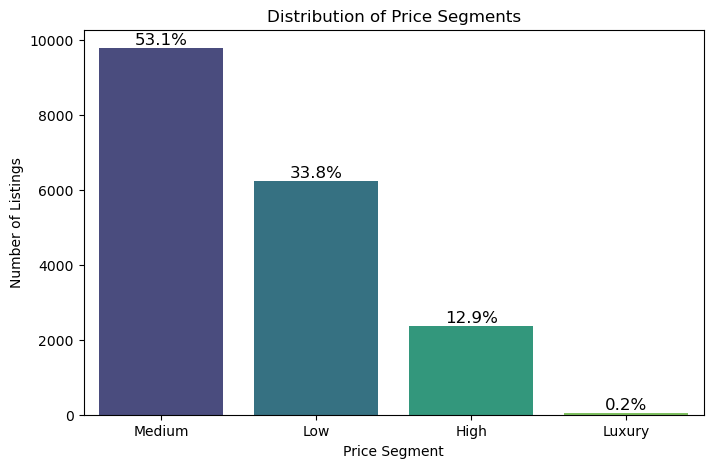

In [25]:
# Define the price segments
def segment_price(price):
    if price <= 300000:
        return 'Low'
    elif 300001 <= price <= 1000000:
        return 'Medium'
    elif 1000001 <= price <= 10000000:
        return 'High'
    else:
        return 'Luxury'

# Apply the function to create a new column
me_1['price_segment'] = me_1['price'].apply(segment_price)

# Count the number of listings in each segment
segment_counts = me_1['price_segment'].value_counts()

# Display the counts
print(segment_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Distribution of Price Segments')
plt.xlabel('Price Segment')
plt.ylabel('Number of Listings')

# Adding percentage labels
total = segment_counts.sum()
for i in range(len(segment_counts)):
    plt.text(i, segment_counts.values[i] + 20, f'{segment_counts.values[i]/total*100:.1f}%', 
             ha='center', va='bottom', fontsize=12)
plt.show()

In [26]:
# Define thresholds to check
price_thresholds = [10_000_000, 20_000]

# Count total listings
num_rows = len(me_1)

# Analyze price thresholds
for threshold in price_thresholds:
    count_above = df_cleaned[df_cleaned['price'] > threshold].shape[0]
    percent_above = (count_above / num_rows) * 100
    print(f"Listings with price above ${threshold:,}: {count_above} ({percent_above:.2f}%)")

# Filter for listings with price above $20,000
df_high_price = df_cleaned[df_cleaned['price'] > 20000]

# Display shapes before and after filtering
print(f"\nOriginal cleaned DataFrame shape: {df_cleaned.shape}")
print(f"Filtered DataFrame shape (price > $20,000): {df_high_price.shape}")

# Assign the filtered DataFrame to merged_data
merged_data = df_high_price


Listings with price above $10,000,000: 33 (0.18%)
Listings with price above $20,000: 17521 (95.15%)

Original cleaned DataFrame shape: (17706, 30)
Filtered DataFrame shape (price > $20,000): (17521, 30)


In [27]:
# Remove the row where price equals 475,000,000.0
merged_data = merged_data[merged_data['price'] != 475000000.0]

# Confirm removal
print(f"Remaining rows after removal: {merged_data.shape[0]}")
print(f"Top 10 Maximum Prices:\n{merged_data['price'].nlargest(10)}")

Remaining rows after removal: 17520
Top 10 Maximum Prices:
15450    31000000.0
12987    28000000.0
14087    28000000.0
7769     24500000.0
14953    24500000.0
10829    23750000.0
1825     23500000.0
18013    20500000.0
7386     20000000.0
12113    19995000.0
Name: price, dtype: float64


In [28]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17520 entries, 0 to 18414
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   zpid               17520 non-null  int64  
 1   price              17520 non-null  float64
 2   homeStatus         17520 non-null  object 
 3   homeType           17520 non-null  object 
 4   streetAddress      17520 non-null  object 
 5   city               17520 non-null  object 
 6   state              17520 non-null  object 
 7   zipcode            17520 non-null  float64
 8   county             17506 non-null  object 
 9   yearBuilt          17294 non-null  float64
 10  livingArea         16940 non-null  float64
 11  livingAreaUnits    16944 non-null  object 
 12  bathrooms          17520 non-null  float64
 13  bedrooms           17520 non-null  float64
 14  pageViewCount      17519 non-null  float64
 15  favoriteCount      17519 non-null  float64
 16  propertyTaxRate    17519 no

## 🔹 Tax Data Processing and Filtering

In this step, we process and filter the **tax data** to ensure we are working with the most recent records for each property.

### Steps Taken:
1. **Convert 'lastUpdatedDate' to datetime**:  
   The 'lastUpdatedDate' column is converted to a datetime format for easy manipulation. Invalid entries are set to `NaT` using `errors='coerce'`.

2. **Remove rows with invalid 'lastUpdatedDate'**:  
   We drop any rows where the 'lastUpdatedDate' couldn't be converted, ensuring clean data for further processing.

3. **Sort data by 'zpid' and 'lastUpdatedDate'**:  
   Sorting allows us to group records by property (`zpid`) and ensures that the most recent tax records come first.

4. **Keep only the latest record for each 'zpid'**:  
   By using `drop_duplicates`, we keep the most recent tax record for each property.

5. **Drop the 'lastUpdatedDate' column**:  
   Since we've kept the latest tax record, the 'lastUpdatedDate' is no longer necessary and is dropped.

### Outcome:
The filtered tax dataset is now ready for merging with other datasets. The shape of the filtered dataset is checked to ensure the filtering process worked as intended.



In [30]:
tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362631 entries, 0 to 362630
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   zpid                  362631 non-null  int64  
 1   lastUpdatedTimestamp  362631 non-null  object 
 2   lastUpdatedDate       362631 non-null  object 
 3   valueIncreaseRate     362631 non-null  int64  
 4   taxIncreaseRate       362631 non-null  int64  
 5   taxPaid               214615 non-null  float64
 6   propertyValue         341010 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 19.4+ MB


In [31]:
# 1. Convert 'lastUpdatedDate' to datetime safely
tax['lastUpdatedDate'] = pd.to_datetime(tax['lastUpdatedDate'], errors='coerce')

# 2. Drop rows where 'lastUpdatedDate' couldn't be parsed (optional, but recommended)
tax = tax.dropna(subset=['lastUpdatedDate'])

# 3. Sort by 'zpid' and 'lastUpdatedDate' (latest first)
tax_sorted = tax.sort_values(by=['zpid', 'lastUpdatedDate'], ascending=[True, False])

# 4. Keep only the latest record per 'zpid'
tax_filtered = tax_sorted.drop_duplicates(subset='zpid', keep='first')

# 5. Drop 'lastUpdatedDate' column
tax_filtered.drop(columns=['lastUpdatedDate'], inplace=True)

# 6. Check shape
print("Filtered shape:", tax_filtered.shape)


Filtered shape: (14395, 6)


## 🔹 Mortgage Data Cleaning and Preprocessing

In this step, we clean and preprocess the **mortgage data** to make it ready for merging and further analysis.

### Steps Taken:

1. **Remove Duplicate Rows by 'zpid'**:  
   We drop duplicate rows based on the 'zpid' column to ensure that each property has a single entry in the dataset.

2. **Replace Rare 'bucketType' Categories**:  
   The rare categories `'30 Year Fixed Bucket'` and `'15 Year Fixed Bucket'` are replaced with the more general `'Fixed Rate Bucket'`. This reduces the complexity of the data and avoids overfitting during modeling.

3. **Impute Missing 'rate' Values**:  
   Missing values in the `'rate'` column are filled using the median rate within each `'bucketType'`. This ensures that the imputation is realistic and preserves the data distribution.

4. **Drop 'lastUpdatedDate' Column**:  
   If the 'lastUpdatedDate' column exists, it is dropped since it is no longer necessary for analysis.

5. **Output Status Checks**:  
   After performing the cleaning steps, we check for missing values and verify the updated distribution of the `'bucketType'` column to ensure the changes were applied correctly.

### Outcome:
The cleaned **mortgage dataset** is now ready for further analysis and merging with other datasets.


In [33]:
mortgage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98502 entries, 0 to 98501
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zpid                  98502 non-null  int64  
 1   bucketType            98502 non-null  object 
 2   rate                  93667 non-null  float64
 3   rateSource            98502 non-null  object 
 4   lastUpdatedTimestamp  98502 non-null  object 
 5   lastUpdatedDate       98502 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.5+ MB


In [34]:
# 1. Re-create the cleaned mortgage dataframe (one row per zpid)
mortgage_cleaned = mortgage.drop_duplicates(subset=['zpid'])

# 2. Replace rare categories with a general one
mortgage_cleaned['bucketType'] = mortgage_cleaned['bucketType'].replace(
    ['30 Year Fixed Bucket', '15 Year Fixed Bucket'],
    'Fixed Rate Bucket'
)

# 3. Impute missing 'rate' values using the median rate within each 'bucketType'
mortgage_cleaned['rate'] = mortgage_cleaned.groupby('bucketType')['rate'].transform(
    lambda x: x.fillna(x.median())
)

# 4. Drop the 'lastUpdatedDate' column if it exists
if 'lastUpdatedDate' in mortgage_cleaned.columns:
    mortgage_cleaned.drop(columns=['lastUpdatedDate'], inplace=True)

# 5. Output status checks
print("Missing values after imputation:\n", mortgage_cleaned.isnull().sum())
print("\nUpdated 'bucketType' distribution:\n", mortgage_cleaned['bucketType'].value_counts())


Missing values after imputation:
 zpid                    0
bucketType              0
rate                    0
rateSource              0
lastUpdatedTimestamp    0
dtype: int64

Updated 'bucketType' distribution:
 bucketType
Arm 5 Bucket         18242
Fixed Rate Bucket        9
Name: count, dtype: int64


In [35]:
# Replace the rare categories with a new category "Fixed Rate Bucket"
mortgage_cleaned['bucketType'] = mortgage_cleaned['bucketType'].replace(
    ['30 Year Fixed Bucket', '15 Year Fixed Bucket'], 'Fixed Rate Bucket')

# Verify the updated value counts
print(mortgage_cleaned['bucketType'].value_counts())


bucketType
Arm 5 Bucket         18242
Fixed Rate Bucket        9
Name: count, dtype: int64


## 🔹 Merging Mortgage and Tax DataFrames

After cleaning both the **mortgage** and **tax** data, we now merge them into a single DataFrame to create a unified dataset for further analysis.

### Steps Taken:

1. **Merge Mortgage and Tax DataFrames**:  
   The cleaned **mortgage** and **tax** datasets are merged on the `'zpid'` column, which uniquely identifies each property. A **left join** is used, meaning that all rows from the **mortgage** dataset are retained, and corresponding rows from the **tax** dataset are included when available.

2. **Remove Unnecessary Columns**:  
   After the merge, we drop the columns `'lastUpdatedTimestamp_y'` and `'rateSource'`, which are either duplicates or irrelevant to the analysis.

3. **Verify the Merged Data**:  
   Finally, we check the first few rows of the merged DataFrame to ensure the merge was successful and the data looks correct.

### Outcome:
The merged **mortgage and tax data** is now combined into a single DataFrame (`merged_df`), ready for further analysis and modeling.


In [37]:
merged_df = mortgage_cleaned.merge(tax_filtered, on='zpid', how='left')
merged_df.drop(columns=['lastUpdatedTimestamp_y','rateSource'], inplace=True)
print(merged_df.head())

        zpid         bucketType   rate       lastUpdatedTimestamp_x  \
0   34119484  Fixed Rate Bucket  6.346    2024-11-29 06:07:07.7 UTC   
1   14513801  Fixed Rate Bucket  6.396  2024-11-29 09:02:19.465 UTC   
2  244454750       Arm 5 Bucket  6.692  2024-11-29 09:01:57.523 UTC   
3  402291717  Fixed Rate Bucket  5.557  2024-11-29 09:02:12.339 UTC   
4   15117126  Fixed Rate Bucket  6.574  2024-11-29 06:55:57.617 UTC   

   valueIncreaseRate  taxIncreaseRate   taxPaid  propertyValue  
0                0.0              0.0   6410.68       107000.0  
1                0.0              0.0   7811.38       169280.0  
2                0.0              0.0       NaN            NaN  
3                NaN              NaN       NaN            NaN  
4               16.0             16.0  13508.26      1089360.0  


## 🔹  Merge with Master DataFrame

After performing individual merges, optimizations, and cleaning on the **mortgage** and **tax** data, we now integrate the newly created DataFrame with the original **master DataFrame** to create a comprehensive dataset.

### Steps Taken:

1. **Optimize Data Types**:  
   - **Reduce float precision**: We reduce the precision of floating-point numbers from `float64` to `float32` to save memory without losing too much information.
   - **Convert object columns with low cardinality to category**: Columns with a small number of unique values (low cardinality) are converted to the `category` data type to improve performance, especially when the number of unique values is much smaller than the total number of records.
   - **Convert date columns to datetime**: We ensure that all date columns (`datePosted`, `timeOnZillow`, `dateSold`, `lastUpdated`, `lastUpdatedDate`) are correctly converted to the `datetime` format for easier manipulation and analysis.

2. **Drop Columns with High Null Percentage**:  
   - Columns with more than 50% missing values are dropped from the DataFrame to avoid potential biases or inefficiencies when training machine learning models.

3. **Merge DataFrames on 'zpid'**:  
   - We use the `merge()` function to combine the **master DataFrame** (`merged_data`) with the cleaned **tax and mortgage data** (`merged_df`) on the `'zpid'` column. This creates a unified dataset for further analysis.

4. **Drop Irrelevant or Redundant Columns**:  
   - We drop certain columns that are not relevant for the analysis or are redundant, such as `'streetAddress'`, `'url'`, `'lastUpdatedTimestamp_x'`, and `'taxPaid'`. This step helps to keep the dataset clean and focused on essential features.

5. **Final Check**:  
   - We print the shape and summary info of the final DataFrame to ensure that the merge was successful and that the dataset is ready for the next phase of analysis or modeling.

### Outcome:
We create **master DataFrame** (`data`) now contains a comprehensive set of features, including **mortgage** and **tax** details, which are ready for analysis or predictive modeling.
or predictive modeling.


In [39]:
# --- Step 1: Optimize data types ---
# Reduce float precision
merged_df[merged_df.select_dtypes('float64').columns] = merged_df.select_dtypes('float64').astype('float32')

# Convert object columns with low cardinality to category
merged_df = merged_df.apply(lambda col: col.astype('category') 
                            if col.dtype == 'object' and col.nunique() / len(merged_df) < 0.1 else col)

# Convert date columns to datetime
for col in ['datePosted', 'timeOnZillow', 'dateSold', 'lastUpdated', 'lastUpdatedDate']:
    if col in merged_df.columns:
        merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

# --- Step 2: Drop columns with high null percentage ---
merged_df.drop(columns=merged_df.columns[merged_df.isnull().mean() * 100 > 50], inplace=True)

# --- Step 3: Merge on 'zpid' ---
merged_df.set_index('zpid', inplace=True)
merged_data.set_index('zpid', inplace=True)
data = merged_data.merge(merged_df, how='inner', left_index=True, right_index=True).reset_index()

# --- Step 4: Drop irrelevant or redundant columns ---
columns_to_drop = [
    'streetAddress',
    'url',
    'lastUpdatedTimestamp_x',
    'taxPaid',
    'livingAreaUnits'
]
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

# --- Final check ---
print(f"Final DataFrame shape: {data.shape}")
print(data.info())


Final DataFrame shape: (17508, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17508 entries, 0 to 17507
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   zpid               17508 non-null  int64   
 1   price              17508 non-null  float64 
 2   homeStatus         17508 non-null  object  
 3   homeType           17508 non-null  object  
 4   city               17508 non-null  object  
 5   state              17508 non-null  object  
 6   zipcode            17508 non-null  float64 
 7   county             17506 non-null  object  
 8   yearBuilt          17282 non-null  float64 
 9   livingArea         16928 non-null  float64 
 10  bathrooms          17508 non-null  float64 
 11  bedrooms           17508 non-null  float64 
 12  pageViewCount      17507 non-null  float64 
 13  favoriteCount      17507 non-null  float64 
 14  propertyTaxRate    17507 non-null  float64 
 15  is_FSBA           

## 🔹 Historical Price Data Processing and Integration

In this section, we focused on processing the historical price data (`pr_his`) to extract key features that will help us understand pricing trends and behavior over time. The goal was to calculate several historical price metrics, which include the most recent price, average price, median price, and price change rate for each property (`zpid`). These metrics will play a key role in our modeling process.

### 1. **Data Preprocessing**

The first step involved cleaning and converting key columns in the historical price data to ensure they were in a suitable format for further analysis.

- **Datetime Conversion**:  
  The `dateOfEvent` and `lastUpdated` columns were converted to `datetime` format to allow proper manipulation of date-related data. This enables us to track price changes over time and perform time-based analysis.

- **Boolean Conversion for Rentals**:  
  The `postingIsRental` column, which indicates whether a property is listed as a rental, was converted to a Boolean type (`True`/`False`). This transformation makes it easier to analyze rental vs non-rental properties in subsequent analyses.

### 2. **Sorting and Grouping for Historical Price Analysis**

The data was sorted by `zpid` (property ID) and `dateOfEvent` to ensure that the most recent price events appear first for each property. This sorting is critical for calculating the price metrics based on the most recent data.

Next, we calculated several key historical price metrics:

- **Most Recent Price**: The first price entry for each property (`zpid`) was taken as the most recent price event.
- **Average Price**: The average price across all historical entries for each property was calculated to capture general price trends.
- **Median Price**: The median price for each property was computed to reduce the influence of outliers.
- **Price Change Rate**: The difference between the most recent price and the earliest price was calculated to determine how much the price had changed over time.

### 3. **Extracting Key Metrics**

Once the necessary price metrics were calculated, we focused on the most recent record for each property to ensure we were working with the latest data. The calculated historical price metrics were then mapped to the most recent records to enrich the dataset with relevant pricing features.

The most recent price records were retained, and redundant columns such as `price`, `priceChangeRate`, and `lastUpdated` were removed to clean up the dataset and make it more manageable.

### 4. **Merging with the Master Dataset**

After processing the historical price data, we merged it with our main **master DataFrame** (`data`) to integrate the calculated historical price metrics into the broader dataset. This merge was done using the `zpid` (property ID) to ensure that each property had its corresponding price metrics from the historical dataset.

The merged dataset was then reorganized so that the `zpid` column would appear first, improving the structure and readability of the DataFrame. We ensured that all properties from the master dataset were included, even if there was no corresponding historical price data, by using a left join during the merge.

### 5. **Final Dataset Overview**

After merging the historical price data, the final dataset contains additional features, such as:

- **Most Recent Price**: The most up-to-date price for each property.
- **Average Price**: The average price over the property's entire history.
- **Median Price**: The median price, which provides a more robust measure against extreme price values.
- **Price Change Rate**: The change in price from the earliest to the most recent listing.

These new features are now part of the master dataset and will be used in the next stages of analysis and modeling to better understand property pricing trends.

### Outcome

By processing and integrating the historical price data, we have successfully enhanced the master dataset with key pricing features that will aid in predictive modeling and analysis. The enriched dataset provides a more comprehensive view of each property’s price history, which will be crucial in building models that can predict future property prices or identify trends.

This process not only improves our dataset but also sets the stage for more advanced analyses and predictive modeling in the next phases of the project.

---


In [41]:
pr_his.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247960 entries, 0 to 247959
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   zpid                247960 non-null  int64  
 1   event               247960 non-null  object 
 2   price               233359 non-null  float64
 3   pricePerSquareFoot  216745 non-null  float64
 4   priceChangeRate     247960 non-null  float64
 5   dateOfEvent         247960 non-null  object 
 6   source              245105 non-null  object 
 7   postingIsRental     247960 non-null  bool   
 8   lastUpdated         247960 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 15.4+ MB


In [42]:
# --- Step 1: Initial Conversion ---
pr_his['dateOfEvent'] = pd.to_datetime(pr_his['dateOfEvent'], errors='coerce')
pr_his['lastUpdated'] = pd.to_datetime(pr_his['lastUpdated'], errors='coerce')

# --- Step 2: Convert postingIsRental to Boolean ---
pr_his['postingIsRental'] = pr_his['postingIsRental'].astype(bool)

# --- Step 3: Sort by zpid and event date for historical analysis ---
pr_his_sorted = pr_his.sort_values(by=['zpid', 'dateOfEvent'], ascending=[True, False])

# --- Step 4: Calculate historical price metrics ---
hist_most_recent_price = pr_his_sorted.groupby('zpid')['price'].first()
hist_average_price = pr_his_sorted.groupby('zpid')['price'].mean()
hist_median_price = pr_his_sorted.groupby('zpid')['price'].median()
hist_price_change_rate = pr_his_sorted.groupby('zpid')['price'].apply(lambda x: x.iloc[0] - x.iloc[-1])

# --- Step 5: Get most recent record per zpid ---
pr_his_most_recent = pr_his_sorted.drop_duplicates(subset='zpid', keep='first')

# --- Step 6: Add the historical price metrics to the most recent records ---
pr_his_most_recent['hist_most_recent_price'] = pr_his_most_recent['zpid'].map(hist_most_recent_price)
pr_his_most_recent['hist_average_price'] = pr_his_most_recent['zpid'].map(hist_average_price)
pr_his_most_recent['hist_median_price'] = pr_his_most_recent['zpid'].map(hist_median_price)
pr_his_most_recent['hist_price_change_rate'] = pr_his_most_recent['zpid'].map(hist_price_change_rate)

# --- Step 7: Drop redundant columns ---
pr_his_cleaned = pr_his_most_recent.drop(columns=['price', 'priceChangeRate', 'lastUpdated'])

# --- Step 8: Final output preview ---
print(pr_his_cleaned[['zpid', 'pricePerSquareFoot', 'hist_most_recent_price',
                      'hist_average_price', 'hist_median_price', 'hist_price_change_rate']].head())


           zpid  pricePerSquareFoot  hist_most_recent_price  \
227675  1069739               102.0                199000.0   
225540  1069757               116.0                159900.0   
227664  1069763               101.0                165000.0   
227527  1070379                73.0                125000.0   
226410  1070692                68.0                110000.0   

        hist_average_price  hist_median_price  hist_price_change_rate  
227675       199000.000000           199000.0                     0.0  
225540       163233.333333           162400.0                -10000.0  
227664       165000.000000           165000.0                     0.0  
227527       103000.000000            96000.0                 30000.0  
226410       128333.333333           129000.0                -34000.0  


### Merging with History with master data 

In [44]:
# Merge the dataframes
merged_data = data.merge(pr_his_cleaned, left_on='zpid', right_on='zpid', how='left')

# Move 'zpid' to the first column
columns_order = ['zpid'] + [col for col in merged_data.columns if col != 'zpid']
merged_data = merged_data[columns_order]

# Display the first few rows to verify
print(merged_data.head())

        zpid      price homeStatus       homeType         city state  zipcode  \
0  348939329    89900.0   For Sale  Single Family       Austin    TX  78741.0   
1  442720817  1381900.0   For Sale  Single Family    San Diego    CA  92129.0   
2  442717169   529900.0   For Sale   Multi Family      Houston    TX  77021.0   
3  442707890   197999.0   For Sale  Single Family  San Antonio    TX  78263.0   
4   43812298   719900.0   For Sale  Single Family        Miami    FL  33127.0   

              county  yearBuilt  livingArea  ...  propertyValue  \
0      Travis County     2024.0       748.0  ...            NaN   
1   San Diego County     2024.0      1738.0  ...            NaN   
2      Harris County     2024.0      2766.0  ...            NaN   
3       Bexar County     2024.0      1213.0  ...            NaN   
4  Miami-Dade County     2024.0         0.0  ...       151922.0   

             event  pricePerSquareFoot  dateOfEvent                source  \
0  Listed for sale               

## 🔹 Merging Nearby Schools' Data

In this section, we integrate nearby schools' data (`ne_sch`) with our existing dataset (`merged_data`). The goal is to calculate key metrics related to nearby schools, such as school ratings, distances from the property to the schools, and the types of schools, to enhance the features in our final dataset.

### 1. **Aggregating School Data by Property (`zpid`)**

We begin by aggregating the school data at the `zpid` level, which corresponds to each property. We perform several operations to generate useful features:

- **Average, Maximum, and Minimum School Rating**:  
  Calculate the mean, maximum, and minimum school ratings for each property.

- **School Distance Metrics**:  
  Calculate the nearest, average, and farthest distance from the property to nearby schools.

- **Concatenate Unique School Information**:  
  Combine unique school names, grade levels, and types for each property.

### 2. **Flattening and Renaming Columns**

After aggregating the data, the columns are multi-level. To make them more accessible, we flatten the multi-level column names and rename them for clarity. This will help in later steps when analyzing and merging the data.

### 3. **Mapping School Types and Grade Levels**

To simplify the data, we map the school types and grade levels into broader categories:

- **School Types**:  
  We map various school types (such as 'Public', 'Charter', and their combinations) into more consistent categories like `Public`, `Charter`, and `Charter & Public`.

- **Grade Levels**:  
  We categorize grade levels (e.g., 'High', 'Middle', 'Primary', 'Elementary') into broader groups such as `High`, `Middle`, `Primary`, and `Other`.

### 4. **Calculating School Rating and Distance Ranges**

Next, we create two new columns to represent the range of school ratings and distances:

- **School Rating Range**:  
  This is calculated by subtracting the minimum school rating from the maximum school rating.

- **School Distance Range**:  
  The range of school distances is computed by subtracting the nearest school distance from the farthest school distance.

### 5. **Final Adjustments and Cleanup**

In this step, we perform additional cleanup to remove unnecessary columns and rename others for consistency. For example, we drop the 'school_names' column and rename 'grade_levels' to 'school_grade_levels'.

### 6. **Merging with the Master Dataset**

Once the school data is processed and transformed, we merge it with the main dataset (`merged_data`). The `zpid` column is used as a common identifier between both datasets. We perform a `left` join to ensure that all properties from the main dataset are retained, even if there is no corresponding school data.

We also reorder the columns to place `zpid` at the beginning for consistency.

### 7. **Final Dataset Review**

After the merge, the `final_merged` dataset now includes enhanced features related to nearby schools, including:

- **Average, Maximum, and Minimum School Ratings**
- **Average, Nearest, and Farthest School Distances**
- **School Types**
- **School Rating and Distance Ranges**
- **Grade Levels**

These features will provide valuable insights for further analysis or modeling, and they offer a better understanding of the properties' proximity to schools.


In [46]:
# Aggregate data to get a single row per zpid
zpid_aggregated = (
    ne_sch.groupby('zpid')
    .agg({
        'schoolRating': ['mean', 'max', 'min'],  # Aggregates for schoolRating
        'distanceFromListing': ['min', 'mean', 'max'],  # Aggregates for distanceFromListing
        'schoolName': lambda x: ', '.join(set(x)),  # Unique school names concatenated
        'gradeLevel': lambda x: ', '.join(set(x)),  # Unique grade levels concatenated
        'type': lambda x: ', '.join(set(x)),  # Unique school types concatenated
    })
)

# Flatten the multi-level column index created by .agg()
zpid_aggregated.columns = [
    '_'.join(col).strip() for col in zpid_aggregated.columns.values
]

# Reset index to make 'zpid' a column
zpid_aggregated = zpid_aggregated.reset_index()

# Rename columns for clarity
zpid_aggregated.rename(
    columns={
        'schoolRating_mean': 'avg_school_rating',
        'schoolRating_max': 'max_school_rating',
        'schoolRating_min': 'min_school_rating',
        'distanceFromListing_min': 'nearest_school_distance',
        'distanceFromListing_mean': 'avg_school_distance',
        'distanceFromListing_max': 'farthest_school_distance',
        'schoolName_<lambda>': 'school_names',
        'gradeLevel_<lambda>': 'grade_levels',
        'type_<lambda>': 'school_types',
    },
    inplace=True
)

# Result: Single row per zpid
print(zpid_aggregated.info())
print(zpid_aggregated.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18414 entries, 0 to 18413
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   zpid                      18414 non-null  int64  
 1   avg_school_rating         18414 non-null  float64
 2   max_school_rating         18414 non-null  float64
 3   min_school_rating         18414 non-null  float64
 4   nearest_school_distance   18414 non-null  float64
 5   avg_school_distance       18414 non-null  float64
 6   farthest_school_distance  18414 non-null  float64
 7   school_names              18414 non-null  object 
 8   grade_levels              18414 non-null  object 
 9   school_types              18414 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 1.4+ MB
None
      zpid  avg_school_rating  max_school_rating  min_school_rating  \
0  1069739           2.666667                5.0                1.0   
1  1069757           2

In [47]:
# 1. Map 'school_types' to simplified categories
school_type_mapping = {
    'Public': 'Public',
    'Charter': 'Charter',
    'Public, Charter': 'Charter & Public',
    'Charter, Public': 'Charter & Public'
}
zpid_aggregated['school_types'] = zpid_aggregated['school_types'].map(school_type_mapping)
print("School types distribution:\n", zpid_aggregated['school_types'].value_counts())

# 2. Map 'grade_levels' to grouped categories
def map_grade_levels(grade):
    if 'High' in grade:
        return 'High'
    elif 'Middle' in grade:
        return 'Middle'
    elif 'Primary' in grade or 'Elementary' in grade:
        return 'Primary'
    else:
        return 'Other'

zpid_aggregated['grade_levels'] = zpid_aggregated['grade_levels'].apply(map_grade_levels)
print("Grade levels distribution:\n", zpid_aggregated['grade_levels'].value_counts())

# 3. Create a range column for school ratings and drop the original min/max columns
zpid_aggregated['school_rating_range'] = (
    zpid_aggregated['max_school_rating'] - zpid_aggregated['min_school_rating']
)
zpid_aggregated.drop(['max_school_rating', 'min_school_rating'], axis=1, inplace=True)

# 4. Create a range column for school distances and drop the original farthest/nearest columns
zpid_aggregated['school_distance_range'] = (
    zpid_aggregated['farthest_school_distance'] - zpid_aggregated['nearest_school_distance']
)
zpid_aggregated.drop(['farthest_school_distance', 'nearest_school_distance'], axis=1, inplace=True)


School types distribution:
 school_types
Public              17743
Charter & Public      593
Charter                78
Name: count, dtype: int64
Grade levels distribution:
 grade_levels
High       16709
Middle      1355
Primary      350
Name: count, dtype: int64


In [48]:
# Drop the 'school_names' column
zpid_aggregated = zpid_aggregated.drop(columns=['school_names'])

# Rename 'grade_levels' to 'school_grade_levels'
zpid_aggregated = zpid_aggregated.rename(columns={'grade_levels': 'school_grade_levels'})

# Verify the changes
zpid_aggregated.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18414 entries, 0 to 18413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zpid                   18414 non-null  int64  
 1   avg_school_rating      18414 non-null  float64
 2   avg_school_distance    18414 non-null  float64
 3   school_grade_levels    18414 non-null  object 
 4   school_types           18414 non-null  object 
 5   school_rating_range    18414 non-null  float64
 6   school_distance_range  18414 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1007.1+ KB


In [49]:
# Merge the aggregated zpid data with the master data
# Using 'left' join to keep all rows from 'merged_data' (left DataFrame) and match zpid with zpid_aggregated (right DataFrame)
final_merged = merged_data.merge(zpid_aggregated, on='zpid', how='left')

# Move 'zpid' to the first column if it is not already
columns_order = ['zpid'] + [col for col in final_merged.columns if col != 'zpid']
final_merged = final_merged[columns_order]

# Check the first few rows of the merged data
# print(final_merged.head())


## 🔹 Merging Nearby Homes Information for Comparison

In this section, we integrate and compare nearby homes' data (`pr_homes`) with the main dataset (`final_merged`). The goal is to evaluate home types and price comparisons for properties, ensuring that the data is clean and relevant before merging into the final dataset.

### 1. **Remove Unknown Home Types**

We begin by filtering out rows where the home type is labeled as "Home Type Unknown," keeping only the rows that contain valid home types.

### 2. **Merge with Main Dataset and Filter Matching Home Types**

Next, we merge the `pr_homes` dataset with the `me_1` dataset based on the `zpid` column. We then filter the resulting dataset to keep only the rows where the home type from both datasets matches.

### 3. **Count Comparison Between Original and Matched Datasets**

We perform a comparison of the home type distribution in the original `pr_homes` dataset and the filtered `pr_ho` dataset. This comparison helps to understand how many rows matched the home types after filtering.

### 4. **Keep Closest `priceComp` to Mean Price per `zpid`**

For each property (`zpid`), we calculate the mean price and select the row where the `priceComp` is closest to the mean price. This ensures that the comparison is based on the most representative price.

### 5. **Summary Stats of Price Comparison**

We then calculate summary statistics for the `price` and `priceComp` columns to gain insights into the distribution of prices before and after filtering.

### 6. **Keep Only Relevant Columns**

We narrow down the dataset to only the most relevant columns, including `zpid`, `priceComp`, and `homeTypeComp`. This ensures that we retain only the essential information for further analysis.

### 7. **Merge into Final Dataset**

Finally, we perform a left join between the `final_merged` dataset and the filtered `pr_ho` dataset based on the `zpid` column. This step adds the `priceComp` and `homeTypeComp` information into the main dataset.

### Final Checks

Once the merge is complete, we verify the resulting dataset by checking its shape and columns to ensure that the merging operation was successful.


In [51]:
pr_homes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239767 entries, 0 to 239766
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   zpid                 239767 non-null  int64  
 1   zpidComp             239767 non-null  int64  
 2   addressComp          239749 non-null  object 
 3   cityComp             239766 non-null  object 
 4   stateComp            239762 non-null  object 
 5   zipComp              239759 non-null  float64
 6   priceComp            239767 non-null  int64  
 7   homeTypeComp         239767 non-null  object 
 8   homeStatusComp       239767 non-null  object 
 9   livingAreaValueComp  213820 non-null  float64
 10  livingAreaUnitsComp  213820 non-null  object 
 11  lotAreaValueComp     178238 non-null  float64
 12  lotAreaUnitsComp     239767 non-null  object 
 13  lastUpdated          239767 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 25.6+ MB


In [52]:
# 1. Remove unknown home types
pr_homes = pr_homes[pr_homes['homeTypeComp'] != 'Home Type Unknown']

# 2. Merge with main dataset and filter matching home types
merged_df = me_1.merge(pr_homes, on='zpid', how='inner')
pr_ho = merged_df[merged_df['homeType'] == merged_df['homeTypeComp']]

# 3. Count comparison between original and matched datasets
pr_counts = pr_homes['homeTypeComp'].value_counts().rename_axis('homeTypeComp').reset_index(name='pr_homes_count')
pr_ho_counts = pr_ho['homeTypeComp'].value_counts().rename_axis('homeTypeComp').reset_index(name='filtered_df_count')
comparison_df = pd.merge(pr_counts, pr_ho_counts, on='homeTypeComp', how='outer')
comparison_df[['pr_homes_count', 'filtered_df_count']] = comparison_df[['pr_homes_count', 'filtered_df_count']].fillna(0).astype(int)

# 4. Keep closest priceComp to mean price per zpid
mean_prices = pr_ho.groupby('zpid')['price'].mean().rename('mean_price')
pr_ho = pr_ho.merge(mean_prices, on='zpid')
pr_ho['price_diff'] = np.abs(pr_ho['priceComp'] - pr_ho['mean_price'])
pr_ho = pr_ho.loc[pr_ho.groupby('zpid')['price_diff'].idxmin()]
pr_ho = pr_ho.drop(columns=['mean_price', 'price_diff'])

# 5. Summary stats of price comparison
stats = pd.DataFrame({
    'price': pr_ho['price'].describe(),
    'priceComp': pr_ho['priceComp'].describe()
})

# 6. Keep only relevant columns
pr_ho = pr_ho[['zpid', 'priceComp', 'homeTypeComp']]

# 7. Merge into final dataset
merged_data = final_merged.merge(
    pr_ho,
    on='zpid',
    how='left',
    suffixes=('', '_comp')
)

# Final checks
print(merged_data.shape)
print(merged_data.columns)


(17508, 49)
Index(['zpid', 'price', 'homeStatus', 'homeType', 'city', 'state', 'zipcode',
       'county', 'yearBuilt', 'livingArea', 'bathrooms', 'bedrooms',
       'pageViewCount', 'favoriteCount', 'propertyTaxRate', 'is_FSBA',
       'is_comingSoon', 'is_newHome', 'is_pending', 'is_forAuction',
       'is_foreclosure', 'is_bankOwned', 'is_openHouse', 'is_FSBO',
       'duration_in_hours', 'latest_Updated', 'days_since', 'bucketType',
       'rate', 'valueIncreaseRate', 'taxIncreaseRate', 'propertyValue',
       'event', 'pricePerSquareFoot', 'dateOfEvent', 'source',
       'postingIsRental', 'hist_most_recent_price', 'hist_average_price',
       'hist_median_price', 'hist_price_change_rate', 'avg_school_rating',
       'avg_school_distance', 'school_grade_levels', 'school_types',
       'school_rating_range', 'school_distance_range', 'priceComp',
       'homeTypeComp'],
      dtype='object')


## 🔹 Data Imputation Process

In this section, we handle missing values across various columns in the dataset using different imputation techniques. Each imputation method was selected based on the nature of the column and the type of data it holds.

### 1. **Impute Missing Values in 'county'**

The missing values in the `county` column are imputed with the default value `'Orange County'`.

### 2. **Impute Missing Categorical Values Using Mode per 'event'**

For categorical columns such as `source`, `postingIsRental`, and `dateOfEvent`, we impute missing values based on the mode (most frequent value) for each specific `event`. If the mode is not available, a fallback value is used:
- `'N/A'` for non-date columns
- `'1970-01-01'` for `dateOfEvent`.

### 3. **Impute 'duration_in_hours' Using Mean per 'event'**

Missing values in the `duration_in_hours` column are imputed with the mean of the `duration_in_hours` for each respective `event`. If no valid mean is found, the missing value is filled with `0`.

### 4. **Impute 'days_since' Using Median per 'event'**

The `days_since` column is imputed with the median value of `days_since` for each specific `event`. If the median value is unavailable, the missing value is filled with `0`.

### 5. **Impute Numerical Columns Grouped by ['zipcode', 'homeType'] with Fallback to Global Median**

For numerical columns like `valueIncreaseRate`, `taxIncreaseRate`, and `propertyValue`, missing values are imputed first by the median value within each group defined by `zipcode` and `homeType`. If no group median is available, the global median is used.

### 6. **Impute 'yearBuilt' with Smart Logic**

The `yearBuilt` column is treated with special logic:
- First, we replace any absurd values such as `0` or `9999` with `NaN`.
- Then, missing values are imputed with the median value within each group defined by `homeType` and `zipcode`. If no group median is available, the global median is used for imputation.

### 7. **Final Check for Remaining Nulls**

After the imputation process, a final check is performed to ensure no missing values remain in any of the imputed columns. The number of remaining `NaN` values in each column is printed.


In [54]:
# 1. Impute missing values in 'county'
merged_data['county'].fillna('Orange County', inplace=True)

# 2. Impute missing categorical values using mode per 'event'
for column in ['source', 'postingIsRental', 'dateOfEvent']:
    for idx, row in merged_data.iterrows():
        if pd.isna(row[column]):
            mode_value = merged_data[merged_data['event'] == row['event']][column].mode()
            fallback = 'N/A' if column != 'dateOfEvent' else "1970-01-01"
            merged_data.at[idx, column] = mode_value.iloc[0] if not mode_value.empty else fallback

# 3. Impute 'duration_in_hours' using mean per 'event'
for idx, row in merged_data.iterrows():
    if pd.isna(row['duration_in_hours']):
        group_mean = merged_data[merged_data['event'] == row['event']]['duration_in_hours'].mean()
        merged_data.at[idx, 'duration_in_hours'] = group_mean if not pd.isna(group_mean) else 0

# 4. Impute 'days_since' using median per 'event'
for idx, row in merged_data.iterrows():
    if pd.isna(row['days_since']):
        group_median = merged_data[merged_data['event'] == row['event']]['days_since'].median()
        merged_data.at[idx, 'days_since'] = group_median if not pd.isna(group_median) else 0

# 5. Impute numerical values grouped by ['zipcode', 'homeType'] → fallback to global median
numerical_cols = ['valueIncreaseRate', 'taxIncreaseRate', 'propertyValue']
for col in numerical_cols:
    merged_data[col] = merged_data.groupby(['zipcode', 'homeType'])[col].transform(
        lambda x: x.fillna(x.median())
    )
    merged_data[col] = merged_data[col].fillna(merged_data[col].median())

# 6. Impute 'yearBuilt' with smart logic (replace absurd values then group-impute)
merged_data['yearBuilt'].replace([0, 9999], np.nan, inplace=True)
merged_data['yearBuilt'] = merged_data.groupby(['homeType', 'zipcode'])['yearBuilt'].transform(
    lambda x: x.fillna(x.median())
)
merged_data['yearBuilt'] = merged_data['yearBuilt'].fillna(merged_data['yearBuilt'].median())

# 7. Final check - print remaining nulls
print("Remaining nulls per column:")
print("county:", merged_data['county'].isnull().sum())
print("source:", merged_data['source'].isnull().sum())
print("postingIsRental:", merged_data['postingIsRental'].isnull().sum())
print("dateOfEvent:", merged_data['dateOfEvent'].isnull().sum())
print("duration_in_hours:", merged_data['duration_in_hours'].isnull().sum())
print("days_since:", merged_data['days_since'].isnull().sum())
print("valueIncreaseRate:", merged_data['valueIncreaseRate'].isnull().sum())
print("taxIncreaseRate:", merged_data['taxIncreaseRate'].isnull().sum())
print("propertyValue:", merged_data['propertyValue'].isnull().sum())
print("yearBuilt:", merged_data['yearBuilt'].isnull().sum())


Remaining nulls per column:
county: 0
source: 0
postingIsRental: 0
dateOfEvent: 0
duration_in_hours: 0
days_since: 0
valueIncreaseRate: 0
taxIncreaseRate: 0
propertyValue: 0
yearBuilt: 0


In [55]:
# Drop rows where 'event' column is NaN
merged_data = merged_data.dropna(subset=['event'])

# Check the result
print(merged_data.shape)  # Verify the new shape of the DataFrame
print(merged_data.head())  # Preview the filtered DataFrame


(17195, 49)
        zpid      price homeStatus       homeType         city state  zipcode  \
0  348939329    89900.0   For Sale  Single Family       Austin    TX  78741.0   
1  442720817  1381900.0   For Sale  Single Family    San Diego    CA  92129.0   
2  442717169   529900.0   For Sale   Multi Family      Houston    TX  77021.0   
3  442707890   197999.0   For Sale  Single Family  San Antonio    TX  78263.0   
4   43812298   719900.0   For Sale  Single Family        Miami    FL  33127.0   

              county  yearBuilt  livingArea  ...  hist_median_price  \
0      Travis County     2024.0       748.0  ...            89900.0   
1   San Diego County     2024.0      1738.0  ...          1381883.0   
2      Harris County     2024.0      2766.0  ...           529900.0   
3       Bexar County     2024.0      1213.0  ...           197999.0   
4  Miami-Dade County     2024.0         0.0  ...           165000.0   

   hist_price_change_rate  avg_school_rating  avg_school_distance  \
0    

## 🔹 Imputation of Specific Columns with Mode

In this section, we focus on imputing missing values for specific columns in the dataset using the mode (most frequent value). This method is applied to categorical or numerical columns where the mode is a reasonable value to fill missing entries.

### 1. **Columns for Imputation**

The following columns are selected for imputation:
- `pageViewCount`
- `favoriteCount`
- `propertyTaxRate`
- `hist_most_recent_price`
- `hist_average_price`
- `hist_median_price`

### 2. **Impute Missing Values Using Mode**

For each of the selected columns, the mode (the most frequent value) is calculated, and the missing values (`NaN`) are imputed with the mode. This is done for all columns listed in `columns_to_impute`.

### 3. **Final Check for Null Values**

After the imputation, a final check is performed to confirm that there are no remaining `NaN` values in the imputed columns. The number of missing values is printed for each of the columns to ensure all missing data has been handled correctly.


In [57]:
# Define columns for imputation
columns_to_impute = [
    'pageViewCount',
    'favoriteCount',
    'propertyTaxRate',
    'hist_most_recent_price',
    'hist_average_price',
    'hist_median_price'
]

# Impute the mode for each column
for column in columns_to_impute:
    if column in merged_data.columns:
        # Calculate mode and fill NaN values with it
        mode_value = merged_data[column].mode()[0]  # Get the first mode
        merged_data[column].fillna(mode_value, inplace=True)

# Check the result
print(merged_data[columns_to_impute].isnull().sum())  # Verify there are no nulls left
# print(merged_data[columns_to_impute].head())  # Preview the imputed columns


pageViewCount             0
favoriteCount             0
propertyTaxRate           0
hist_most_recent_price    0
hist_average_price        0
hist_median_price         0
dtype: int64


## 🔹 Cleaning 'livingArea' Values

In this section, we clean the 'livingArea' values to ensure the data is valid and within reasonable bounds. The cleaning process involves removing outliers and rows with invalid or missing values.

### 1. **Remove Invalid 'livingArea' Values**

First, we remove rows where the 'livingArea' is greater than 1 and less than 400, as these values are considered too small to be valid for typical properties.

### 2. **Drop Rows with 'livingArea' Equal to 0 or Missing**

Next, we drop rows where 'livingArea' is either 0 or contains missing values (`NaN`), as these are invalid entries that should not be included in the cleaned dataset.

### 3. **Display Summaries Before and After Cleaning**

Finally, we display summary statistics of the 'livingArea' column before and after the cleaning process to compare the changes and ensure the data is now clean.


In [59]:
# --- Clean 'livingArea' values ---
# Step 1: Remove rows where 'livingArea' is >1 and <400 (considered too small to be valid)
merged_data = merged_data[~((merged_data['livingArea'] > 1) & (merged_data['livingArea'] < 400))]

# Step 2: Drop rows where 'livingArea' is 0 or NaN
merged_data_cleaned = merged_data[~((merged_data['livingArea'] == 0) | merged_data['livingArea'].isna())]

# Step 3: Display summaries before and after cleaning
print("Before cleaning:")
print(merged_data['livingArea'].describe())

print("\nAfter cleaning:")
print(merged_data_cleaned['livingArea'].describe())


Before cleaning:
count    16612.000000
mean      1871.961293
std       1298.563229
min          0.000000
25%       1192.000000
50%       1633.000000
75%       2261.000000
max      49087.000000
Name: livingArea, dtype: float64

After cleaning:
count    16068.000000
mean      1935.338623
std       1273.065673
min          1.000000
25%       1225.750000
50%       1665.000000
75%       2294.000000
max      49087.000000
Name: livingArea, dtype: float64


## 🔹 Imputation of 'homeTypeComp' and 'priceComp'

In this section, we perform imputations on the `homeTypeComp` and `priceComp` columns to handle missing values and ensure the completeness of the dataset.

### 1. **Impute 'homeTypeComp' Using 'homeType'**

We impute the missing values in the `homeTypeComp` column by filling them with the corresponding values from the `homeType` column. This ensures that `homeTypeComp` is populated with valid values wherever it was missing.

After the imputation, we report the number of remaining null values in the `homeTypeComp` column to verify the success of the imputation process.

### 2. **Impute 'priceComp' Using Geographic Hierarchy (Zipcode > City > County)**

We impute the missing values in the `priceComp` column using a hierarchical approach based on geographic location:

- First, we check if the `priceComp` value is available for the same `zipcode`.
- If not, we look for the `priceComp` value within the same `city`.
- If that also fails, we check at the `county` level.
- If all levels fail, the `priceComp` remains missing.

This approach ensures that we impute the `priceComp` value using the most granular geographic information available.

After applying the imputation, we report the number of missing values in the `priceComp` column to verify the result.


In [61]:
# --- Impute 'homeTypeComp' using 'homeType' ---
merged_data_cleaned['homeTypeComp'] = merged_data_cleaned['homeTypeComp'].fillna(merged_data_cleaned['homeType'])

# Report nulls after homeTypeComp imputation
null_counts_after_imputation = merged_data_cleaned['homeTypeComp'].isnull().sum()
print(f"Remaining null values in 'homeTypeComp' after imputation: {null_counts_after_imputation}")

# --- Impute 'priceComp' using geographic hierarchy: zipcode > city > county ---
def impute_priceComp(row, data):
    if pd.notnull(row['priceComp']):
        return row['priceComp']

    zipcode_group = data[(data['zipcode'] == row['zipcode']) & (data['priceComp'].notnull())]
    if not zipcode_group.empty:
        return zipcode_group['priceComp'].median()

    city_group = data[(data['city'] == row['city']) & (data['priceComp'].notnull())]
    if not city_group.empty:
        return city_group['priceComp'].median()

    county_group = data[(data['county'] == row['county']) & (data['priceComp'].notnull())]
    if not county_group.empty:
        return county_group['priceComp'].median()

    return row['priceComp']

# Apply hierarchical imputation
merged_data_cleaned['priceComp'] = merged_data_cleaned.apply(impute_priceComp, axis=1, data=merged_data_cleaned)

# Report nulls after priceComp imputation
missing_after_imputation = merged_data_cleaned['priceComp'].isnull().sum()
print(f"Missing values in 'priceComp' after imputation: {missing_after_imputation}")


Remaining null values in 'homeTypeComp' after imputation: 0
Missing values in 'priceComp' after imputation: 0


## 🔹 Imputation for 'hist_price_change_rate' and 'pricePerSquareFoot'

In this section, we address the missing values in the `hist_price_change_rate` and `pricePerSquareFoot` columns through imputation methods, ensuring the dataset remains robust and complete.

### 1. **Imputation for 'hist_price_change_rate'**

We first compute basic statistics (mean, median, and mode) for the `hist_price_change_rate` column to better understand the distribution of the data.

Next, we perform group-based median imputation for missing values in `hist_price_change_rate` based on the `bucketType` category. This method fills in missing values with the median value within the same `bucketType`, ensuring that similar properties receive similar imputed values.

If any missing values remain after the group-based imputation, we fill them with the overall median of the `hist_price_change_rate` column as a fallback.

### 2. **Imputation for 'pricePerSquareFoot'**

Similarly, we compute the overall median for the `pricePerSquareFoot` column to use it as a fallback for missing values.

We then perform group-based median imputation for missing values in `pricePerSquareFoot`, grouping by `homeType`, `city`, and `zipcode`. This approach ensures that properties with similar characteristics are imputed with comparable values.

As a fallback, if any missing values persist after the group-based imputation, we fill them with the overall median of the `pricePerSquareFoot` column.

### 3. **Final Check**

We perform an optional final check to verify if any missing values remain across all columns in the cleaned dataset.


In [63]:
# --- Imputation for 'hist_price_change_rate' ---
# Compute basic statistics
mean_rate = merged_data_cleaned['hist_price_change_rate'].mean()
median_rate = merged_data_cleaned['hist_price_change_rate'].median()
mode_rate = merged_data_cleaned['hist_price_change_rate'].mode()[0]

# Group-based median imputation by 'bucketType'
merged_data_cleaned['hist_price_change_rate'] = merged_data_cleaned.groupby('bucketType')['hist_price_change_rate'].transform(
    lambda x: x.fillna(x.median())
)

# Fallback to overall median
if merged_data_cleaned['hist_price_change_rate'].isna().sum() > 0:
    merged_data_cleaned['hist_price_change_rate'].fillna(median_rate, inplace=True)

# --- Imputation for 'pricePerSquareFoot' ---
# Compute overall median
overall_median = merged_data_cleaned['pricePerSquareFoot'].median()

# Group-based median imputation by 'homeType', 'city', and 'zipcode'
merged_data_cleaned['pricePerSquareFoot'] = merged_data_cleaned.groupby(['homeType', 'city', 'zipcode'])['pricePerSquareFoot'].transform(
    lambda x: x.fillna(x.median())
)

# Fallback to overall median
if merged_data_cleaned['pricePerSquareFoot'].isna().sum() > 0:
    merged_data_cleaned['pricePerSquareFoot'].fillna(overall_median, inplace=True)

# Optional: Check remaining nulls across all columns
print(merged_data_cleaned.isna().sum())


zpid                      0
price                     0
homeStatus                0
homeType                  0
city                      0
state                     0
zipcode                   0
county                    0
yearBuilt                 0
livingArea                0
bathrooms                 0
bedrooms                  0
pageViewCount             0
favoriteCount             0
propertyTaxRate           0
is_FSBA                   0
is_comingSoon             0
is_newHome                0
is_pending                0
is_forAuction             0
is_foreclosure            0
is_bankOwned              0
is_openHouse              0
is_FSBO                   0
duration_in_hours         0
latest_Updated            0
days_since                0
bucketType                0
rate                      0
valueIncreaseRate         0
taxIncreaseRate           0
propertyValue             0
event                     0
pricePerSquareFoot        0
dateOfEvent               0
source              

In [64]:
merged_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16068 entries, 0 to 17507
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   zpid                    16068 non-null  int64         
 1   price                   16068 non-null  float64       
 2   homeStatus              16068 non-null  object        
 3   homeType                16068 non-null  object        
 4   city                    16068 non-null  object        
 5   state                   16068 non-null  object        
 6   zipcode                 16068 non-null  float64       
 7   county                  16068 non-null  object        
 8   yearBuilt               16068 non-null  float64       
 9   livingArea              16068 non-null  float64       
 10  bathrooms               16068 non-null  float64       
 11  bedrooms                16068 non-null  float64       
 12  pageViewCount           16068 non-null  float64    

## 🔹 Outlier Removal Based on 'priceComp'

In this step, we handle potential outliers in the dataset by applying a price threshold to the `priceComp` column.

### 1. **Removing Outliers**

We set a threshold to filter out listings with a `priceComp` less than $20,000, as we consider these values as potential outliers that may skew the analysis.

### 2. **Post-Cleaning Check**

After applying the filter, we check the shape and content of the cleaned dataset to ensure that the outlier removal was successfully applied and no further outlier_data_cleaned)


In [66]:
merged_data_cleaned = merged_data_cleaned[merged_data_cleaned['priceComp'] >= 20000]
print(merged_data_cleaned.shape)
print(merged_data_cleaned)

(15986, 49)
            zpid      price     homeStatus       homeType           city  \
0      348939329    89900.0       For Sale  Single Family         Austin   
1      442720817  1381900.0       For Sale  Single Family      San Diego   
2      442717169   529900.0       For Sale   Multi Family        Houston   
3      442707890   197999.0       For Sale  Single Family    San Antonio   
5      402142668   735000.0       For Sale      Townhouse      Nashville   
...          ...        ...            ...            ...            ...   
17503  352427429   703478.0  Recently Sold  Single Family      Nashville   
17504   32332472   550000.0  Recently Sold  Single Family  Staten Island   
17505   20183958   820000.0  Recently Sold  Single Family     Northridge   
17506   41068816   265000.0  Recently Sold  Single Family        Madison   
17507  376393152   690530.0  Recently Sold  Single Family      Nashville   

      state  zipcode              county  yearBuilt  livingArea  ...  \
0  

In [67]:
# Convert 'dateOfEvent' to datetime
merged_data_cleaned['dateOfEvent'] = pd.to_datetime(merged_data_cleaned['dateOfEvent'])

# Extract features from 'dateOfEvent'
merged_data_cleaned['year_of_event'] = merged_data_cleaned['dateOfEvent'].dt.year
merged_data_cleaned['month_of_event'] = merged_data_cleaned['dateOfEvent'].dt.month
merged_data_cleaned['day_of_week'] = merged_data_cleaned['dateOfEvent'].dt.dayofweek

# Drop the original 'dateOfEvent'
merged_data_cleaned = merged_data_cleaned.drop(columns=['dateOfEvent'])


## 🔹 Label Encoding for 'homeStatus'

In this step, we apply label encoding to the `homeStatus` column to convert categorical values into numeric values. This process helps prepare the data for machine learning models that require numerical input.

### 1. **Defining the Mapping**

We define a mapping for `homeStatus` to assign numeric labels:
- 'For Sale' is mapped to 0
- 'Recently Sold' is mapped to 1
- 'Pending' is mapped to 2
- 'Foreclosed' and 'Pre Foreclosure' are both mapped to 3 (since they represent similar statuses).

### 2. **Apply the Mapping**

We use the `.map()` function to apply this mapping and create a new column `homeStatus_category`, which holds the encoded values.

### 3. **Convert to Categorical**

The new column is then converted to a categorical type to optimize memory and ensure that it is appropriately handled by subsequent processes.

### 4. **Check the Updated DataFrame**

Finally, we check the structure of the updated DataFrame to confirm that the encoding nfo())
print(merged_data_cleaned.head())


In [69]:
# Filter the DataFrame to include only columns with dtype 'object' and display info
merged_data_cleaned.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 0 to 17507
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   homeStatus           15986 non-null  object
 1   homeType             15986 non-null  object
 2   city                 15986 non-null  object
 3   state                15986 non-null  object
 4   county               15986 non-null  object
 5   event                15986 non-null  object
 6   source               15986 non-null  object
 7   postingIsRental      15986 non-null  object
 8   school_grade_levels  15986 non-null  object
 9   school_types         15986 non-null  object
 10  homeTypeComp         15986 non-null  object
dtypes: object(11)
memory usage: 1.5+ MB


### Redundancy:
Since `homeTypeComp` is derived from the neighborhood information and the `homeType` column directly represents the type of property, both columns may be conveying similar information, especially when prices are concerned. Adding both could result in overfitting or confusion, especially if the other column is more relevant for pricing.


#### Apply One-Hot Encoding on homeType

In [72]:
# Step 1: Define the mapping
home_status_mapping = {
    'For Sale': 0,                  # For Sale
    'Recently Sold': 1,            # Sold
    'Pending': 2,                  # Transaction in progress
    'Foreclosed': 3,               # Not for Sale (Auction, Foreclosed)
    'Pre Foreclosure': 3           # Not for Sale (Auction, Pre-Foreclosure)
}

# Step 2: Map the values
merged_data_cleaned['homeStatus_category'] = merged_data_cleaned['homeStatus'].map(home_status_mapping)

# Step 3: Convert to category type
merged_data_cleaned['homeStatus_category'] = merged_data_cleaned['homeStatus_category'].astype('category')

# Optional: Preview the changes
print(merged_data_cleaned['homeStatus'].value_counts())
print(merged_data_cleaned['homeStatus_category'].value_counts())
print(merged_data_cleaned.dtypes['homeStatus_category'])


homeStatus
For Sale           12707
Recently Sold       3237
Pending               27
Foreclosed             8
Pre Foreclosure        7
Name: count, dtype: int64
homeStatus_category
0    12707
1     3237
2       27
3       15
Name: count, dtype: int64
category


## 🏡 Label Encoding for `homeType` and Dropping Redundant Columns

### 1. Label Encoding: `homeType`
- **Mapping Creation**:  
  Mapped the `homeType` column into numerical categories using a custom dictionary:
  - `Single Family` → 0
  - `Condo` → 1
  - `Townhouse` → 2
  - `Multi Family` → 3
  - `Manufactured` → 4
  - `Apartment` → 5

- **Encoding Process**:
  - Applied the mapping to create a new column `homeType_category`.
  - Converted `homeType_category` to a categorical data type for efficient storage and modeling.

- **Validation**:
  - Verified the counts of both the original `homeType` and the newly created `homeType_category`.
  - Checked the final data type to ensure proper conversion.

---

### 2. Dropping Redundant Columns
- Removed unnecessary or redundant columns to streamline the dataset:
  - `'homeType'`, `'homeTypeComp'`, `'homeStatus'`
  - Location-based columns: `'county'`, `'city'`, `'state'`
  - Source tracking and metadata: `'source'`, `'latest_Updated'`, `'bucketType'`

- **Reasoning**:
  - After successful encoding and feature engineering, the original columns became redundant.
  - Dropping these features reduces noise and helps prepare the data for efficient modeling.

---

### ✅ Summary
At this point, the dataset is:
- **Lighter**, with only the necessary columns retained.
- **Numerically encoded**, making it modeling-ready for machine learning workflows!


In [74]:
# Step 1: Define the mapping for homeType
home_type_mapping = {
    'Single Family': 0,   # Single Family
    'Condo': 1,           # Condo
    'Townhouse': 2,       # Townhouse
    'Multi Family': 3,    # Multi Family
    'Manufactured': 4,    # Manufactured
    'Apartment': 5        # Apartment
}

# Step 2: Map the values
merged_data_cleaned['homeType_category'] = merged_data_cleaned['homeType'].map(home_type_mapping)

# Step 3: Convert to category type
merged_data_cleaned['homeType_category'] = merged_data_cleaned['homeType_category'].astype('category')

# Optional: Preview the changes
print(merged_data_cleaned['homeType'].value_counts())
print(merged_data_cleaned['homeType_category'].value_counts())
print(merged_data_cleaned.dtypes['homeType_category'])


homeType
Single Family    10456
Condo             2708
Townhouse         1999
Multi Family       647
Manufactured       116
Apartment           60
Name: count, dtype: int64
homeType_category
0    10456
1     2708
2     1999
3      647
4      116
5       60
Name: count, dtype: int64
category


In [75]:
# Drop the columns
merged_data_cleaned.drop(['homeType','homeTypeComp','homeStatus', 'county','city','state','source','latest_Updated', 'bucketType'], axis=1, inplace=True)


In [76]:
merged_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 0 to 17507
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   zpid                    15986 non-null  int64   
 1   price                   15986 non-null  float64 
 2   zipcode                 15986 non-null  float64 
 3   yearBuilt               15986 non-null  float64 
 4   livingArea              15986 non-null  float64 
 5   bathrooms               15986 non-null  float64 
 6   bedrooms                15986 non-null  float64 
 7   pageViewCount           15986 non-null  float64 
 8   favoriteCount           15986 non-null  float64 
 9   propertyTaxRate         15986 non-null  float64 
 10  is_FSBA                 15986 non-null  bool    
 11  is_comingSoon           15986 non-null  bool    
 12  is_newHome              15986 non-null  bool    
 13  is_pending              15986 non-null  bool    
 14  is_forAuction           159

### Encoding School Grade Levels

We map the `school_grade_levels` column into numerical categories to prepare it for modeling:

- **Primary** → 1
- **Middle** → 2
- **High** → 3

This encoded column is saved as `school_grade_levels_encoded`.


In [78]:
# Define the mapping for school_grade_levels
grade_level_mapping = {
    'Primary': 1,
    'Middle': 2,
    'High': 3
}

# Map the school_grade_levels column to numerical values
merged_data_cleaned['school_grade_levels_encoded'] = merged_data_cleaned['school_grade_levels'].map(grade_level_mapping)


In [79]:
# Drop the  columns
merged_data_cleaned.drop(['school_grade_levels', 'school_types'], axis=1, inplace=True)

### Encoding Event Feature Using Target Mean Encoding

We encode the `event` column by replacing each event with the **mean price** associated with that event:

- Calculate the average `price` for each unique `event`.
- Map these averages back to create a new `event_encoded` column.
- Drop the original `event` column after encoding.


In [81]:
# Calculate mean price for each unique event
event_target_mean = merged_data_cleaned.groupby('event')['price'].mean()

# Map the mean prices back to the event column
merged_data_cleaned['event_encoded'] = merged_data_cleaned['event'].map(event_target_mean)

# Drop the original event column 
merged_data_cleaned = merged_data_cleaned.drop(columns=['event'])

# Verify the encoding
print(merged_data_cleaned[['event_encoded']].head())


   event_encoded
0  650684.223212
1  634830.259193
2  650684.223212
3  650684.223212
5  650684.223212


### Identify Boolean Columns
We filter the DataFrame to locate columns that have a boolean data type (`bool`).

### Map Boolean Values
Convert the `True` values to `1` and `False` values to `0`.

### Update the DataFrame
The converted columns will be updated directly in the DataFrame to reflect these changes.


In [83]:
# Identify boolean columns and convert them to integers
bool_columns = merged_data_cleaned.select_dtypes(include='bool').columns
print("Boolean columns:", bool_columns.tolist())

# Convert the identified boolean columns to integers
merged_data_cleaned[bool_columns] = merged_data_cleaned[bool_columns].astype(int)


Boolean columns: ['is_FSBA', 'is_comingSoon', 'is_newHome', 'is_pending', 'is_forAuction', 'is_foreclosure', 'is_bankOwned', 'is_openHouse', 'is_FSBO']


In [84]:
merged_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 0 to 17507
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   zpid                         15986 non-null  int64   
 1   price                        15986 non-null  float64 
 2   zipcode                      15986 non-null  float64 
 3   yearBuilt                    15986 non-null  float64 
 4   livingArea                   15986 non-null  float64 
 5   bathrooms                    15986 non-null  float64 
 6   bedrooms                     15986 non-null  float64 
 7   pageViewCount                15986 non-null  float64 
 8   favoriteCount                15986 non-null  float64 
 9   propertyTaxRate              15986 non-null  float64 
 10  is_FSBA                      15986 non-null  int32   
 11  is_comingSoon                15986 non-null  int32   
 12  is_newHome                   15986 non-null  int32   
 13  is_pen

In [85]:
df = merged_data_cleaned

In [86]:
# Filter the DataFrame to include only columns with dtype 'object' and display info
print(df.select_dtypes(include='object').info())
print(df.select_dtypes(include='category').info())
print(df.select_dtypes(include='bool').info())

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 0 to 17507
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   postingIsRental  15986 non-null  object
dtypes: object(1)
memory usage: 249.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 0 to 17507
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   homeStatus_category  15986 non-null  category
 1   homeType_category    15986 non-null  category
dtypes: category(2)
memory usage: 156.5 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 0 to 17507
Empty DataFrame
None


## Modeling 

#### Define X and y

In [89]:
# Define X and y
X = df.drop(columns=['zpid','price', 'postingIsRental','hist_most_recent_price'])  # Drop 'price' and other irrelevant columns
y = df['price']

In [90]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
# Ensure categorical columns are treated properly
categorical_columns = ['homeStatus_category', 'homeType_category']
X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Initialize models
lgb_model = LGBMRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)
xgb_model = XGBRegressor(random_state=42, enable_categorical=True)
etr_model = ExtraTreesRegressor(random_state=42)
hgb_model = HistGradientBoostingRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)  # Vanilla GB

# Stacking model
stacking_model = StackingRegressor(
    estimators=[
        ('extratrees', etr_model),
        ('randomforest', rf_model),
        ('xgboost', xgb_model),
    ],
    final_estimator=RandomForestRegressor(random_state=42)
)

# Train all models
lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
catboost_model.fit(X_train, y_train, cat_features=categorical_columns)
xgb_model.fit(X_train, y_train)
etr_model.fit(X_train, y_train)
hgb_model.fit(X_train, y_train)
gbr_model.fit(X_train, y_train)
stacking_model.fit(X_train, y_train)

# Predictions
lgb_preds = lgb_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
catboost_preds = catboost_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
etr_preds = etr_model.predict(X_test)
hgb_preds = hgb_model.predict(X_test)
gbr_preds = gbr_model.predict(X_test)
stacking_preds = stacking_model.predict(X_test)

# Evaluation function including MAE
def evaluate_model(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Root Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)  # Mean Squared Error
    r2 = r2_score(y_true, y_pred)  # R² Score
    mae = mean_absolute_error(y_true, y_pred)  # Mean Absolute Error
    print(f"{name} RMSE: {rmse:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

# Evaluate all models
evaluate_model("LightGBM", y_test, lgb_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("CatBoost", y_test, catboost_preds)
evaluate_model("XGBoost", y_test, xgb_preds)
evaluate_model("ExtraTrees", y_test, etr_preds)
evaluate_model("HistGradientBoostingRegressor", y_test, hgb_preds)
evaluate_model("GradientBoostingRegressor", y_test, gbr_preds)
evaluate_model("StackingRegressor", y_test, stacking_preds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3731
[LightGBM] [Info] Number of data points in the train set: 12788, number of used features: 35
[LightGBM] [Info] Start training from score 662340.407257
LightGBM RMSE: 233341.1693, MSE: 54448101294.0736, R²: 0.9411, MAE: 55965.2385
Random Forest RMSE: 225514.7696, MSE: 50856911312.4084, R²: 0.9450, MAE: 51846.4717
CatBoost RMSE: 219929.5560, MSE: 48369009611.7690, R²: 0.9477, MAE: 43845.6856
XGBoost RMSE: 278358.0087, MSE: 77483181029.4234, R²: 0.9162, MAE: 52876.4819
ExtraTrees RMSE: 169898.1554, MSE: 28865383195.5619, R²: 0.9688, MAE: 43882.0818
HistGradientBoostingRegressor RMSE: 270623.6109, MSE: 73237138802.6458, R²: 0.9208, MAE: 60330.0594
GradientBoostingRegressor RMSE: 237160.3330, MSE: 56245023559.3402, R²: 0.9391, MAE: 669

### Feature Importance

In [93]:
# Extract feature importances
models = {
    'CatBoost': catboost_model.get_feature_importance(),
    'LightGBM': lgb_model.booster_.feature_importance(),
    'XGBoost': [xgb_model.get_booster().get_score(importance_type='weight').get(f, 0) for f in X_train.columns],
    'RandomForest': rf_model.feature_importances_,
    'ExtraTrees': etr_model.feature_importances_,
    'GradientBoosting': gbr_model.feature_importances_,
}

# Create DataFrame
importance_df = pd.DataFrame({'Feature': X_train.columns})
for model_name, importances in models.items():
    importance_df[model_name] = importances

# Normalize to percentage
for model in models.keys():
    total = importance_df[model].sum()
    importance_df[model] = (importance_df[model] / total) * 100

# Add average and sort
importance_df['Average'] = importance_df[list(models.keys())].mean(axis=1)
importance_df_sorted = importance_df.sort_values(by='Average', ascending=False)

# Save for future use in visualizations
importance_df_sorted.to_csv('cached_feature_importance.csv', index=False)

# Display
print(importance_df_sorted.drop(columns='Average').round(2))


                        Feature  CatBoost  LightGBM  XGBoost  RandomForest  \
24           hist_average_price     29.11      8.80     6.55         62.67   
26       hist_price_change_rate     17.98     13.53     8.02         11.86   
31                    priceComp     13.90     14.23    11.08         14.45   
25            hist_median_price      3.66      7.67     4.69          6.55   
23           pricePerSquareFoot     12.94     14.83    11.26          0.78   
2                    livingArea      7.96     14.43    11.51          1.04   
22                propertyValue      2.46      2.87     3.58          0.20   
3                     bathrooms      3.19      3.10     1.84          0.18   
0                       zipcode      0.22      1.60     6.70          0.17   
1                     yearBuilt      0.71      1.70     4.80          0.10   
19                         rate      1.38      1.73     3.12          0.19   
5                 pageViewCount      0.74      1.80     3.68    

### Cross Validation

In [95]:
def get_cv_rmse_r2_mae_all_models(X, y, cat_features=None, fast_mode=True, verbose=False):
    """
    Perform cross-validation on multiple models and return RMSE, R², and MAE scores.
    
    Parameters:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target vector
        cat_features (list, optional): List of categorical feature names for CatBoost
        fast_mode (bool): If True, uses faster model settings (lower depth, fewer trees)
        verbose (bool): Whether to print NaN diagnostics and fold info

    Returns:
        pd.DataFrame: A summary of RMSE, R², and MAE scores for all models
    """

    # Model definitions with optional fast_mode settings
    def model_defs(fast):
        return {
            "Random Forest": RandomForestRegressor(
                n_estimators=100 if fast else 500,
                max_depth=7 if fast else None,
                n_jobs=-1,
                random_state=42
            ),
            "XGBoost": xgb.XGBRegressor(
                n_estimators=100 if fast else 500,
                max_depth=6 if fast else 10,
                verbosity=0,
                random_state=42,
                n_jobs=-1
            ),
            "LightGBM": lgb.LGBMRegressor(
                n_estimators=100 if fast else 500,
                max_depth=6 if fast else -1,
                learning_rate=0.1,
                n_jobs=-1,
                random_state=42
            ),
            "CatBoost": CatBoostRegressor(
                iterations=100 if fast else 500,
                depth=6 if fast else 10,
                learning_rate=0.1,
                random_state=42,
                verbose=0
            ),
            "ExtraTrees": ExtraTreesRegressor(
                n_estimators=100 if fast else 300,
                max_depth=7 if fast else None,
                n_jobs=-1,
                random_state=42
            ),
            "GradientBoosting": GradientBoostingRegressor(
                n_estimators=100 if fast else 300,
                max_depth=4 if fast else 6,
                random_state=42
            ),
            "HistGradientBoosting": HistGradientBoostingRegressor(
                max_iter=100 if fast else 300,
                max_depth=6 if fast else None,
                random_state=42
            )
        }

    base_models = model_defs(fast_mode)

    stacking_regressor = StackingRegressor(
        estimators=[(k.lower().replace(" ", "_"), v) for k, v in base_models.items()],
        final_estimator=RidgeCV()
    )

    models = base_models.copy()
    models["StackingRegressor"] = stacking_regressor

    results_dict = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        rmse_scores, r2_scores, mae_scores = [], [], []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train_fold = X.iloc[train_idx].copy()
            X_val_fold = X.iloc[val_idx].copy()
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]

            X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce')
            X_val_fold = X_val_fold.apply(pd.to_numeric, errors='coerce')

            X_train_fold.dropna(inplace=True)
            y_train_fold = y_train_fold[X_train_fold.index]

            X_val_fold.dropna(inplace=True)
            y_val_fold = y_val_fold[X_val_fold.index]

            if verbose:
                print(f"Fold {fold} - {model_name}:")
                print("  NaNs in X_train_fold:", X_train_fold.isna().sum().sum())
                print("  NaNs in X_val_fold:", X_val_fold.isna().sum().sum())

            if X_train_fold.empty or X_val_fold.empty:
                if verbose:
                    print(f"  Skipping fold {fold} due to empty data.\n")
                continue

            if model_name == "CatBoost":
                train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
                val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)
                model.fit(train_pool)
                preds = model.predict(val_pool)
            else:
                model.fit(X_train_fold, y_train_fold)
                preds = model.predict(X_val_fold)

            rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
            r2 = r2_score(y_val_fold, preds)
            mae = mean_absolute_error(y_val_fold, preds)  # Calculate MAE

            rmse_scores.append(rmse)
            r2_scores.append(r2)
            mae_scores.append(mae)  # Append MAE for each fold

        results_dict[model_name] = {
            'RMSE Scores': np.round(rmse_scores, 4),
            'Mean RMSE': f"{np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}",
            'R² Scores': np.round(r2_scores, 4),
            'Mean R²': f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}",
            'MAE Scores': np.round(mae_scores, 4),  # Display MAE scores
            'Mean MAE': f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}"  # Mean MAE
        }

    return pd.DataFrame(results_dict).T


In [96]:
# To set CatBoost categorical features
cat_features = ['homeStatus_category', 'homeType_category']

# To run the CV with the updated function
results_df = get_cv_rmse_r2_mae_all_models(X_train, y_train, cat_features=cat_features, fast_mode=True, verbose=False)

# To display results
print(results_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 10230, number of used features: 35
[LightGBM] [Info] Start training from score 667089.575758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 